# Assignment 1

This exercise is meant to help you get familiar with some language data. 

The corpus used is the **Penn Treebank**, which is a collection of data from the newspaper 
The Wall Street Journal. The exercise will not take more than a few lines of code; the idea is to examine the data, and notice interesting properties.

## Required software

### Easy installation

The easiest way to get the required software is to install Anaconda. See https://www.continuum.io/downloads . It contains all required packages, including python and jupyter. You can choose python 2.7 or 3.5.

### Manual installation

Make sure that you have `numpy` and `matplotlib` installed. If you don't, you can use e.g. `pip install <package> --user` (python2) or `pip3 install <package> --user` (python3).

## Submission
We will grade your assignments with pass/fail/good, so don't forget to hand them in! 
Choose `File->Download as->HTML` and check if the HTML-file contains all your answers. You can work and submit in pairs. Please e-mail your TA with `"[NLP1] Assignment 1"` as the subject. 
**The deadline for submission is Sunday 6 nov 23:59.**

## Start the notebook

Start a terminal, and `cd` into the directory where you saved the notebook. Then type `jupyter notebook`. Your web browser will open.

## Exercise 1.1

You are provided with a corpus containing words and their Part-of-speech tags in the format is
**word|POS** (one sentence per line) (file name : **sec02-21.gold.tagged**). This data is extracted from Sections 02-21 from the Penn Treebank: these sections are most commonly used for training statistical models (like POS-taggers and parsers).

In [116]:
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import re

In [129]:
def populate_dicts(filename,tolower=False,nonalphanum=False):
    #Define a dictionary to store the tokens. the key is the token and the value is the occurence of it
    tokens = {}
    #Define a dictionary to store the POS.  the key is the POS and the value is the occurence of POS key
    pos_tags = {}
    #Define a dictionary to store the tokens and pos. The key is the word|POS and the value is the occurence of words|POS 
    tokens_pos = {}
    #Start parsing the file
    with open(filename,'r') as f:
        #line-by-line parsing
        for line in f:
            #split with one or more spaces
            linetoken = re.split('\s+',line)
            for token in linetoken:
                token = token.strip() # Strip spaces since it's the same token. Can happen while tokenizing.
                if(tolower): 
                    token = token.lower()
                    #We can also lowercase our words.This decreases the corpus by around ~ 5000 words.
                word_pos_tup = re.split('\|',token)
                if len(token) < 2:
                    continue  #End of line \n causes that  so skip it.
                # We can also strip tokens of non alphanumerical characters to reduce again.
                if (nonalphanum):
                    word_pos_tup[0] = re.sub(r'\W+', '', word_pos_tup[0])
                if len(word_pos_tup) < 2:
                    continue # This might happen in the breakline/remove alphanumeric tokenization .
                
                #POS should be uppercase.
                word_pos_tup[1] = word_pos_tup[1].upper()
                                
                #Put key-value store for token_key = (POS,word)
                tup_key = (word_pos_tup[0],word_pos_tup[1])
                
                # check if we already have the POS elsewise increase it's occurence
                if word_pos_tup[1] in pos_tags:
                    pos_tags[word_pos_tup[1]] = pos_tags[word_pos_tup[1]] + 1
                else:
                    pos_tags[word_pos_tup[1]] = 1
                # check if we have the word key else wise increase it's occurence and add it's POS.
                # this might actually be a bit unecessary since it will only add it's last pos.
                if word_pos_tup[0] in tokens:
                    tokens[word_pos_tup[0]] = (word_pos_tup[1],tokens[word_pos_tup[0]][1] + 1)
                else:
                    tokens[word_pos_tup[0]] = (word_pos_tup[1],1)
                    
                # check if we already have the (word,POS) elsewise icnrease it's occurence
                if tup_key in tokens_pos:
                    tokens_pos[tup_key] = tokens_pos[tup_key] + 1
                else:
                    tokens_pos[tup_key] = 1
    return tokens,pos_tags,tokens_pos


def occurence(index,word,count):
    print '{0:10} ranked corpus word:{1:20} occurences:{2:10}'.format(index,word,count)
    
    
def parse_sentences(filename,sentenceIndx = 2,lower=False,nonalphanum=False):
    ''' Parse a sentence in the given file. We know in 
    our format that a sentence finishes when there is a .|. token.
    Since the file is small we can load the whole contents into a String and tokenize
        Input:
                filename the file to parse sentences
                sentenceIndx the number o sentences we want to parse (Default 2)
                lower flag to lowercase our sentences. (only used if the same applies to our dictionary)
                nonalphanum flag to remove any non alphanumeric characters from tokens.
        Output:
                a list of sentences. Each sentence is a list of words.
    '''
    count = 0
    words = []
    sentences = []
    with open(filename,'r') as f:
        contents = f.read()
        sentences_to_tokenize = contents.split('.|.')
        for i,line  in enumerate(sentences_to_tokenize):
            if(lower):
                line = line.lower()
            word_pos = re.split('\s+',line)
            for word in word_pos:
                token = re.split('\|',word)[0].strip()
                if nonalphanum:
                    token = re.sub(r'\W+', '', token)
                if len(token)< 1:
                    continue
                words.append(token)
            count = count + 1
            sentences.append(words)
            words = []
            if count == sentenceIndx:
                break
    return sentences


def get_multiple_POS(word_pos,verbose=True):
    '''Function to return words with combination of POS in the text.
        Input:  
                word_pos the dictionary with (word,POS) keys.
                verbose  if we want to print them
        Output: 
                multiple_pos a dictionary with word as key and pos combinations counter value
        '''
    multiple_pos = {}
    from collections import Counter
    from  pprint  import pprint

    word_pos_keys = word_pos.keys()
    keys  = [x[0] for x in word_pos_keys]
    # print keys
    pos_tags   = [x[1] for x in word_pos_keys]
    cnt = Counter(keys)
    for i,value in enumerate(cnt.iteritems()):
        if value[1] > 1:
            if verbose:
                print "word: {0:20} POS-combinations: {1}".format(value[0],value[1])
            multiple_pos[value[0]] = value[1]
    return multiple_pos

def get_probabilities(sentence,tokens,verbose=True,laplace=True):
    '''
        Function to return probabilities of a sentence (unigram wise).
        Input:
                sentence a list of words contained in a sentence
                verbose flag if we want to print the probabilities
                laplace flag if we want to apply laplace smoothing
        Output:
                a numpy array with the probabilities of the words.
    '''
    vocab_size = len(tokens.keys())
    occurences = [x[1] for x in tokens.values()]
    total = sum(occurences)
    pw = np.zeros(len(sentence))
    for n,word in enumerate(sentence):
        
        if not word in tokens.keys():
            continue
        if laplace:
            #We also apply laplace smoothing which is actually unecessary since our tokens have been extracted 
            pw[n] = float(tokens[word][1]+1)/(total+vocab_size)
        else:
            pw[n] = float(tokens[word][1]/total)
        # from the corpus therefore there are sure to exist.
        if verbose:
            print 'w_%u\t:\tP(w_%d)\t:\t%.15f\tword:%s'%(n,n,pw[n],word)
    return pw
def plot_freq_rank(tokens,length=None):
    '''Plot log frequency/rank of words graph
        Input:
                tokens the words and occurences dictionary.
                Length if given it will print the occurences until this length of most frequent keys.
        Output: 
                sorted_tokens a words/occurences list of tuples. (key,(POS,count)) format.
        '''

    #Because dictionaries are unordered ,this gets as input the dictionary and returns it as a list of tuples,ordered
    #by the rightmost element of the rightmost primary element. The format of this is (key,(POS,count)) therefore we order
    #by count
    if length:
        sorted_tokens = sorted(tokens.items(), key=lambda x:x[1][1],reverse=True)[0:length]
    else:
        sorted_tokens = sorted(tokens.items(), key=lambda x:x[1][1],reverse=True)
    keys = [x[0] for x in sorted_tokens]
    occurences = [x[1][1] for x in sorted_tokens]
    fig,ax = plt.subplots()
    ax.set_ylabel('Log-Frequency',fontsize=20)
    ax.set_xlabel('Rank',fontsize= 20)
    x = range(len(sorted_tokens))
    fig.set_size_inches(20, 15)
    #plt.bar(x, np.log(occurences),width=1,edgecolor='k',align='center')
    plt.plot(x,np.log(occurences))
#     plt.plot(x,np.log(occurences),'ro',markersize=5)
    if len(sorted_tokens) <=100:
        plt.xticks(x,keys,fontsize=15,rotation='vertical')
    return sorted_tokens


(a) What are the total number of words (tokens) in this corpus? 
What is the number of distinct word types?


### Answer (a):

In [130]:
filename1 = 'sec02-21.gold.tagged'
tokens,pos,word_pos = populate_dicts(filename1)
print 'Distinct number of tokens in corpus:',len(tokens.keys())
occurences = [x[1] for x in tokens.values()]
dev_total = sum(occurences)
print 'Total number of all tokens:',total


Distinct number of tokens in corpus: 44210
Total number of all tokens: 45422


(b) Plot a graph of word frequency versus rank of a word, in this corpus. Does this corpus obey Zipf’s law?

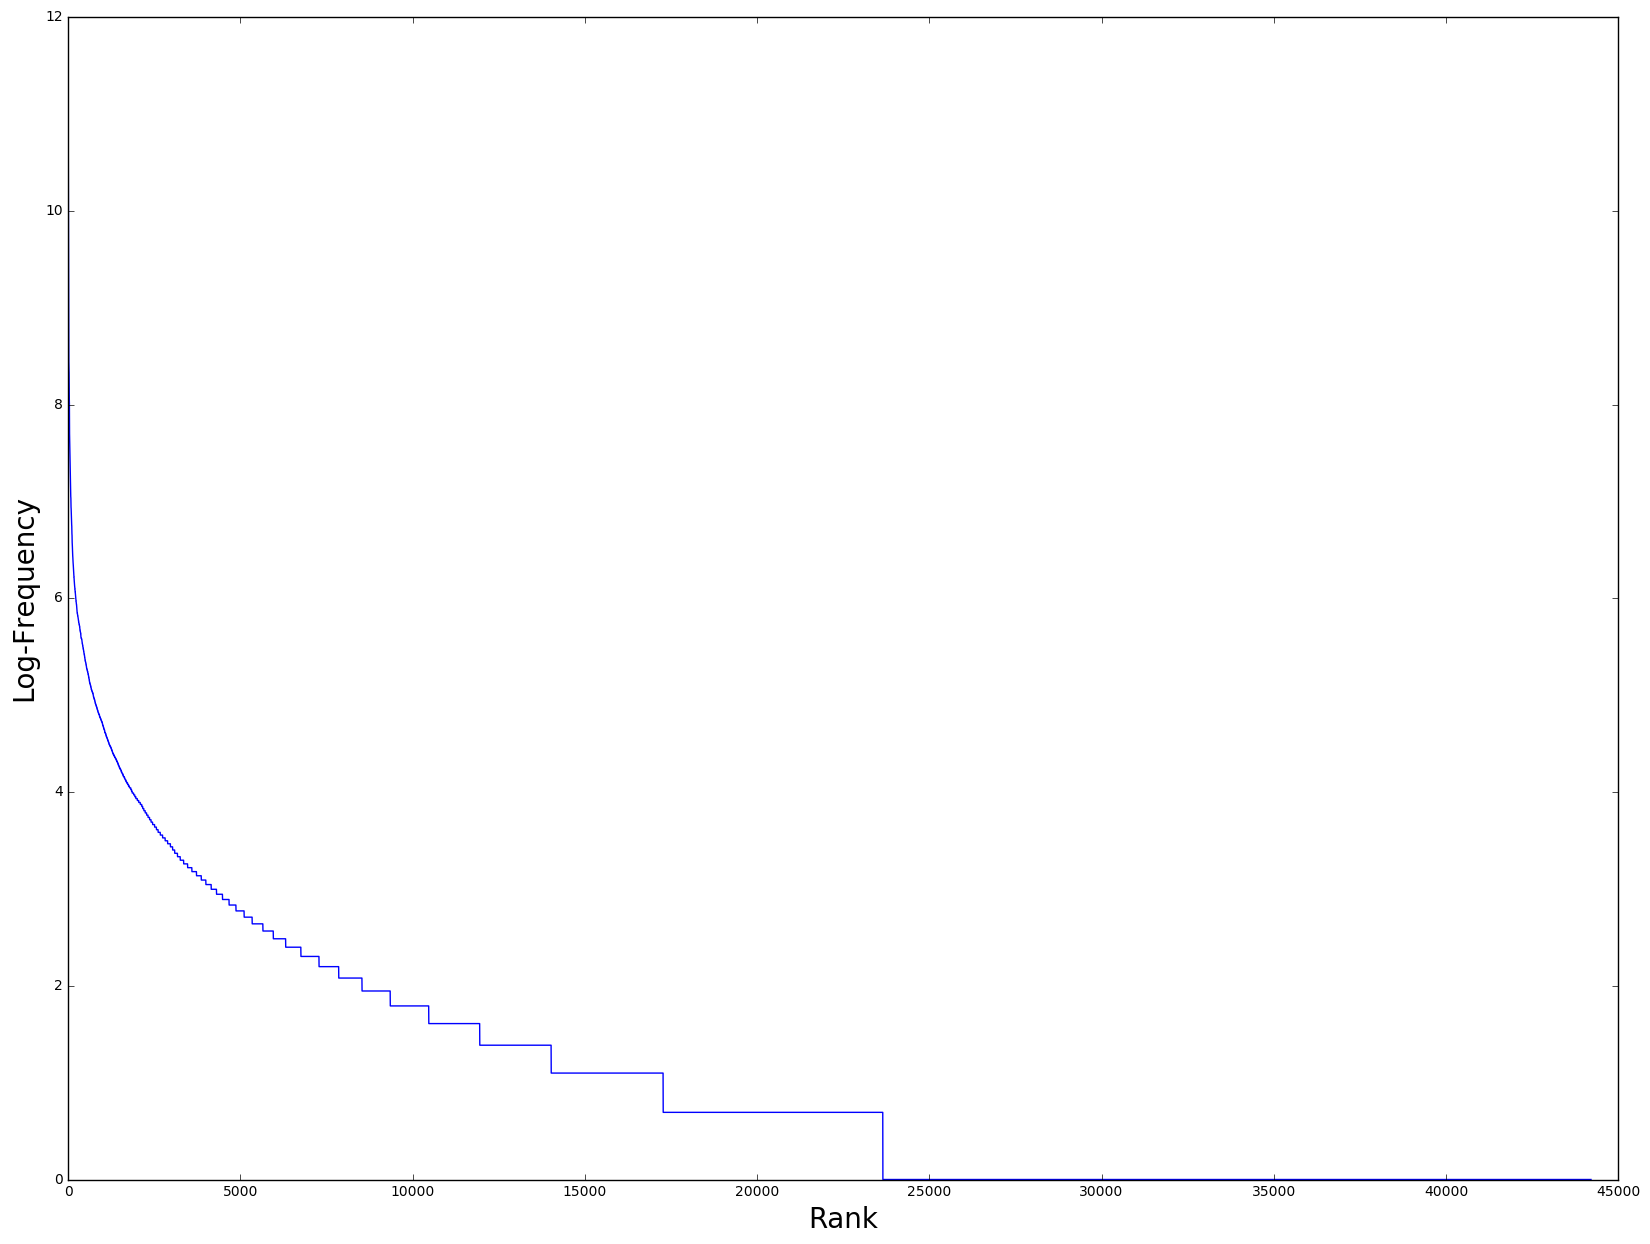

In [131]:
#### PLOT HERE####
sorted_by_freq = plot_freq_rank(tokens,length=None)

(c) What is the 25th most common word in the corpus? How many times does it occur? What about the 50th most common word, the 100th and the 1000th?

In [132]:

index = 25
occurence(index,sorted_by_freq[index-1][0],sorted_by_freq[index-1][1][1])
index = 50
occurence(index,sorted_by_freq[index-1][0],sorted_by_freq[index-1][1][1])
index = 100
occurence(index,sorted_by_freq[index-1][0],sorted_by_freq[index-1][1][1])

        25 ranked corpus word:Mr.                  occurences:      4147
        50 ranked corpus word:had                  occurences:      1755
       100 ranked corpus word:A                    occurences:       860


(d) How many different Part-of-speech tags are present in the corpus?

In [133]:
print('Answer(d):')
print 'Distinct number of POS in corpus:',len(pos.keys())

Answer(d):
Distinct number of POS in corpus: 48


(e) Print a list of the 10 most common part-of-speech tags. Spend a few minutes trying to guess what each tag means, by looking at associated words.

In [134]:
sorted_pos = sorted(pos.items(), key=lambda x:x[1],reverse=True)

for i in range(10):
    print '%u\t frequent POS:\t%s\tCount:%u'%(i+1,sorted_pos[i][0],sorted_pos[i][1])

1	 frequent POS:	NN	Count:132134
2	 frequent POS:	IN	Count:99413
3	 frequent POS:	NNP	Count:90711
4	 frequent POS:	DT	Count:82147
5	 frequent POS:	JJ	Count:59643
6	 frequent POS:	NNS	Count:59332
7	 frequent POS:	,	Count:48314
8	 frequent POS:	.	Count:39252
9	 frequent POS:	CD	Count:36148
10	 frequent POS:	RB	Count:30232


# Rest of answer for (e):
## These are taken from Penn Treenbank's Alphabetical list of part-of-speech tags Project
### <href a="https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html">https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html</href>
1.  NN   Noun, singular or mass 
2.  IN 	Preposition or subordinating conjunction
3.  NNP 	Proper noun, singular 
4.  DT 	Determiner 
5.  JJ   Adjective
6.  NNS  Noun, plural 
7.  ','  Not a POS really , It's punctuation
8.  '.'  Not a POS really , It's punctuation
9.  CD   Cardinal number 
10. RB   Adverb

(f) Assume that the probability $P(w_1^n)$ of a sentence $w_1 \ldots w_n$   can be calculated as follows:

$$P(w_1^n) = P(w_1) \cdot P(w_2) \ldots P(w_n) $$

The probability of a word $w_i$ can be calculated from a corpus as 
$$P(w_i) = \frac{count (w_i)}{N}$$ where $N$ is the total number of word tokens in the corpus. 

What is the probability of the first two sentences in the corpus? 

In [140]:
two_sentences = parse_sentences(filename1)
print '========= First sentence ============='
print ' '.join(two_sentences[0])
pw_sent1 = get_probabilities(two_sentences[0],tokens)
print '========= Second sentence ============='
print ' '.join(two_sentences[1])
pw_sent2 = get_probabilities(two_sentences[1],tokens)
print 'First Sentence Joint probability : %.15e'%(np.prod(pw_sent1))
print 'Second Sentence Joint probability: %.15e'%(np.prod(pw_sent2))


========= First sentence =============
In an Oct. 19 review of The Misanthrope at Chicago 's Goodman Theatre -LRB- Revitalized Classics Take the Stage in Windy City , Leisure & Arts -RRB- , the role of Celimene , played by Kim Cattrall , was mistakenly attributed to Christina Haag
w_0	:	P(w_0)	:	0.001781749544550	word:In
w_1	:	P(w_1)	:	0.003211256960120	word:an
w_2	:	P(w_2)	:	0.000325541559436	word:Oct.
w_3	:	P(w_3)	:	0.000103721443227	word:19
w_4	:	P(w_4)	:	0.000059562808982	word:review
w_5	:	P(w_5)	:	0.023396887535147	word:of
w_6	:	P(w_6)	:	0.006975010320797	word:The
w_7	:	P(w_7)	:	0.000004107779930	word:Misanthrope
w_8	:	P(w_8)	:	0.004430240654287	word:at
w_9	:	P(w_9)	:	0.000202308161543	word:Chicago
w_10	:	P(w_10)	:	0.009499241087658	word:'s
w_11	:	P(w_11)	:	0.000008215559860	word:Goodman
w_12	:	P(w_12)	:	0.000006161669895	word:Theatre
w_13	:	P(w_13)	:	0.001171744224975	word:-LRB-
w_14	:	P(w_14)	:	0.000002053889965	word:Revitalized
w_15	:	P(w_15)	:	0.000002053889965	word:Classics
w

(g) A word may have several part-of-speech tags, for example the word 'record' can be a noun or a verb. How many words do have more than one POS tag? What are the 10 most frequent combinations of POS tags?

In [137]:
print 'Answer(g):'
print '============= Multiple POS words=========='
#We put verbose false to avoid the really large print.
multiple_pos = get_multiple_POS(word_pos,verbose=False)
print 'Multiple POS combination words:',len(multiple_pos.keys())

Answer(g):
============= Multiple POS words==========
Multiple POS combination words: 5955


## Exercise 1.2

You are also provided with another file called **sec00.gold.tagged**. 
Section 00 of the Penn Treebank is typically used as development data.

(a) How many unseen words are present in the development data (i.e., words that have not occurred in the training data)?

In [138]:
filename2 = 'sec00.gold.tagged'
dev_tokens,_,dev_pos = populate_dicts(filename2)
print 'Answer(a):'
print 'Distinct number of tokens in corpus:',len(dev_tokens.keys())
num_dev_tokens = [x[1] for x in dev_tokens.values()]

total = sum(num_dev_tokens)
print 'Total number of all tokens:',total
#Get the NOT intersection of the 2 dictionary key sets.
unseen = list(set(dev_tokens.keys()) - set(tokens.keys()))
print 'Unseen words in '+filename2+":",len(unseen)


Answer(a):
Distinct number of tokens in corpus: 7878
Total number of all tokens: 45422
Unseen words in sec00.gold.tagged: 1288


(b) What are the three most common kind of unseen word (their POS tags)?

In [139]:
unseen_tokens = {x:dev_tokens[x] for x in unseen}
sorted_unseen = sorted(unseen_tokens.items(), key=lambda x:x[1][1],reverse=True)
print 'Answer(b):'
for i in range(3):
    print 'word:',sorted_unseen[i][0],'count:',sorted_unseen[i][1][1],'POS:',sorted_unseen[i][1][0]

Answer(b):
word: Yeargin count: 37 POS: NNP
word: ringers count: 21 POS: NNS
word: Scoring count: 13 POS: NNP
